In [1]:
# --- IMPORTS ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pathlib import Path
import glob
import random
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical # Correction: Import depuis tensorflow.keras.utils
# from tensorflow.keras.preprocessing import image # Moins utilisé avec tf.data

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow Version: 2.19.0
Num GPUs Available:  0


In [ ]:
# --- CONFIGURATION ---
SEED = 100
IMG_SIZE = (128, 128)
BATCH_SIZE = 64 
EPOCHS = 20 
PATIENCE_EARLY_STOPPING = 10 
PATIENCE_REDUCE_LR = 5 
BASE_MODEL_TRAINABLE = True 

# Définir la seed pour la reproductibilité
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

LECTURE ET PRÉPARATION INITIALE DES DONNÉES

In [ ]:
print("\n--- Lecture et Préparation Initiale des Données ---")
try:
    data_dir = '/Users/ayach/tf_env/BreaKHis_v1/histology_slides/breast/'
    if not os.path.isdir(data_dir):
         raise FileNotFoundError(f"Répertoire non trouvé: {data_dir}. Vérifie le chemin.")

    breast_img_paths = glob.glob(os.path.join(data_dir, '**/*.png'), recursive=True)
    if not breast_img_paths:
        raise FileNotFoundError(f"Aucune image .png trouvée dans {data_dir} et ses sous-dossiers.")

    print(f"Nombre total d'images trouvées : {len(breast_img_paths)}")
    for img_path in breast_img_paths[:3]:
        print(img_path)

except FileNotFoundError as e:
    print(f"Erreur critique: {e}")
    print("Vérifie que le dataset BreaKHis est bien présent à l'emplacement attendu.")
    # Quitter si les données ne sont pas trouvées
    exit()


--- Lecture et Préparation Initiale des Données ---
Nombre total d'images trouvées : 7909
/Users/ayach/tf_env/BreaKHis_v1/histology_slides/breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\100X\SOB_B_A-14-22549AB-100-001.png
/Users/ayach/tf_env/BreaKHis_v1/histology_slides/breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\100X\SOB_B_A-14-22549AB-100-002.png
/Users/ayach/tf_env/BreaKHis_v1/histology_slides/breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\100X\SOB_B_A-14-22549AB-100-003.png


In [4]:
# Séparation basée sur les noms de fichiers (Bénin vs Malin)
benign_paths = [img for img in breast_img_paths if Path(img).name.startswith('SOB_B')]
malignant_paths = [img for img in breast_img_paths if Path(img).name.startswith('SOB_M')]

print(f"Nombre d'images bénignes: {len(benign_paths)}")
print(f"Nombre d'images malignes: {len(malignant_paths)}")

# Création des labels (0 pour bénin, 1 pour malin)
labels = [0] * len(benign_paths) + [1] * len(malignant_paths)
all_paths = benign_paths + malignant_paths

# Division Train/Validation/Test (60% Train, 20% Val, 20% Test)
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths, labels, test_size=0.4, random_state=SEED, stratify=labels
)
X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print(f"Taille Train: {len(X_train_paths)}, Validation: {len(X_val_paths)}, Test: {len(X_test_paths)}")


Nombre d'images bénignes: 2480
Nombre d'images malignes: 5429
Taille Train: 4745, Validation: 1582, Test: 1582


# --- FONCTION D'AUGMENTATION ---

In [5]:
def augment_image_tf(image):
    augmented_images = []
    # Image originale
    augmented_images.append(image)

    # Rotations 90, 180 deg + flip horizontal
    for k in [1, 2]:
        rotated_img = tf.image.rot90(image, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)


    # Retourne une liste de tenseurs images augmentées
    return augmented_images


# --- FONCTION DE PREPROCESSING ET CRÉATION DE DATASET TF ---

In [ ]:
def preprocess_image(image_path, label, augment=False, target_size=IMG_SIZE):
    try:
        # Lire l'image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3) # Assurer 3 canaux (RGB)
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32) / 255.0 # Normalisation

        # Appliquer l'augmentation 
        if augment:
            augmented_list = augment_image_tf(image)
            # Convertir la liste d'images en un tenseur
            image_batch = tf.stack(augmented_list)
            # Créer des labels correspondants pour chaque image augmentée
            label_batch = tf.repeat(label, repeats=tf.shape(image_batch)[0])
            return image_batch, label_batch
        else:
            return image, label
    except Exception as e:
        print(f"Erreur pendant le pré-traitement de {image_path}: {e}")
        # Retourner None ou une valeur spéciale pour filtrer plus tard si nécessaire
        return None, None # Ou gérer l'erreur autrement


def create_tf_dataset(paths, labels, batch_size=BATCH_SIZE, augment=False, target_size=IMG_SIZE, num_classes=2):

    # Créer un dataset de base avec les chemins et labels
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((path_ds, label_ds))

    # Mapper la fonction de preprocessing
    ds = ds.map(lambda path, label: preprocess_image(path, label, augment=augment, target_size=target_size),
                num_parallel_calls=tf.data.AUTOTUNE)


    # Si l'augmentation a été appliquée, elle a retourné des batchs d'images/labels
    # Nous devons les "dérouler" pour avoir un dataset plat d'images individuelles
    if augment:
        ds = ds.flat_map(lambda image_batch, label_batch: tf.data.Dataset.from_tensor_slices((image_batch, label_batch)))

    # One-hot encoder les labels
    ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=num_classes)),
                num_parallel_calls=tf.data.AUTOTUNE)

    # Mélanger,répéter, mettre en batch et précharger
    ds = ds.shuffle(buffer_size=len(paths) * (3 if augment else 1)) # Ajuster buffer si augmentation change
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

# --- 2. PREMIÈRE ARCHITECTURE CNN (BASELINE) ---

In [ ]:
print("\n--- Architecture CNN Simple ---")

# Création du modèle CNN Simple
def create_baseline_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') 
    ], name="Baseline_CNN")
    return model

baseline_cnn = create_baseline_cnn(IMG_SIZE + (3,), 2)
baseline_cnn.summary()


--- ÉArchitecture CNN Simple ---


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Préparation des données SANS augmentation
train_ds_no_aug = create_tf_dataset(X_train_paths, y_train, augment=False, num_classes=2)
val_ds_no_aug = create_tf_dataset(X_val_paths, y_val, augment=False, num_classes=2)
test_ds_no_aug = create_tf_dataset(X_test_paths, y_test, augment=False, batch_size=1, num_classes=2) # Batch size 1 pour éval

In [ ]:
# Compilation et Entraînement
baseline_cnn.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

print("Entraînement du modèle Baseline CNN (sans augmentation)...")
start_time = time.time()
history_baseline = baseline_cnn.fit(
    train_ds_no_aug,
    epochs=EPOCHS,
    validation_data=val_ds_no_aug,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOPPING, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE_REDUCE_LR, min_lr=1e-6, verbose=1)
    ]
)
print(f"Temps d'entraînement Baseline CNN: {time.time() - start_time:.2f} sec")


Entraînement du modèle Baseline CNN (sans augmentation)...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 329ms/step - accuracy: 0.6716 - loss: 0.7366 - val_accuracy: 0.6466 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.7734 - loss: 0.5033 - val_accuracy: 0.8319 - val_loss: 0.4444 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.8271 - loss: 0.4466 - val_accuracy: 0.8382 - val_loss: 0.4288 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.8425 - loss: 0.4318 - val_accuracy: 0.8217 - val_loss: 0.4286 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 293ms/step - accuracy: 0.8399 - loss: 0.4240 - val_accuracy: 0.8552 - val_loss: 0.3926 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 289ms/step - accuracy: 0.7982 - loss: 0.4646 - val_accuracy: 0.7718 - val_loss: 0.5034 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━

In [10]:
# Évaluation
loss_baseline, acc_baseline = baseline_cnn.evaluate(test_ds_no_aug, verbose=0)
print(f"Performance Baseline CNN (sans aug): Loss = {loss_baseline:.4f}, Accuracy = {acc_baseline:.4f}")

Performance Baseline CNN (sans aug): Loss = 0.3527, Accuracy = 0.8578


In [11]:
# Sauvegarde
baseline_cnn.save("baseline_cnn_model.keras")
print("Modèle Baseline CNN sauvegardé.")


Modèle Baseline CNN sauvegardé.


# --- 3. AMÉLIORATION AVEC AUGMENTATION DE DONNÉES ---

In [12]:
print("\n--- Amélioration avec Augmentation de Données ---")

# Préparation des données AVEC augmentation
train_ds_aug = create_tf_dataset(X_train_paths, y_train, augment=True, num_classes=2)
# Pour la validation et le test, on n'augmente généralement pas, mais on utilise les mêmes datasets qu'avant
val_ds_aug = val_ds_no_aug # Réutiliser le dataset de validation non augmenté
test_ds_aug = test_ds_no_aug # Réutiliser le dataset de test non augmenté

# Création du modèle (même architecture que baseline)
baseline_cnn_augmented = create_baseline_cnn(IMG_SIZE + (3,), 2)
baseline_cnn_augmented.summary() # Afficher pour confirmer



--- Amélioration avec Augmentation de Données ---


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compilation et Entraînement
baseline_cnn_augmented.compile(optimizer=Adam(learning_rate=0.001),
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

print("Entraînement du modèle Baseline CNN (AVEC augmentation)...")
start_time = time.time()
history_baseline_aug = baseline_cnn_augmented.fit(
    train_ds_aug, # Utiliser le dataset augmenté pour l'entraînement
    epochs=EPOCHS,
    validation_data=val_ds_aug, # Valider sur données non augmentées
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOPPING, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE_REDUCE_LR, min_lr=1e-6, verbose=1)
    ]

)
print(f"Temps d'entraînement Baseline CNN Augmenté: {time.time() - start_time:.2f} sec")


Entraînement du modèle Baseline CNN (AVEC augmentation)...
Epoch 1/20
    223/Unknown 65s 272ms/step - accuracy: 0.7504 - loss: 0.5734

C:\Users\ayach\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


223/223 ━━━━━━━━━━━━━━━━━━━━ 68s 285ms/step - accuracy: 0.7507 - loss: 0.5730 - val_accuracy: 0.8489 - val_loss: 0.4024 - learning_rate: 0.0010
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 68s 287ms/step - accuracy: 0.8462 - loss: 0.4078 - val_accuracy: 0.8559 - val_loss: 0.3861 - learning_rate: 0.0010
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 65s 276ms/step - accuracy: 0.8476 - loss: 0.3991 - val_accuracy: 0.8521 - val_loss: 0.3816 - learning_rate: 0.0010
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 68s 289ms/step - accuracy: 0.8532 - loss: 0.3769 - val_accuracy: 0.8445 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 69s 295ms/step - accuracy: 0.8554 - loss: 0.3674 - val_accuracy: 0.8590 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 71s 298ms/step - accuracy: 0.8597 - loss: 0.3542 - val_accuracy: 0.8477 - val_loss: 0.3463 - learning_rate: 0.0010
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 67s 283ms/step - accuracy: 0.8604 - loss:

In [14]:
# Évaluation
loss_baseline_aug, acc_baseline_aug = baseline_cnn_augmented.evaluate(test_ds_aug, verbose=0)
print(f"Performance Baseline CNN (avec aug): Loss = {loss_baseline_aug:.4f}, Accuracy = {acc_baseline_aug:.4f}")


Performance Baseline CNN (avec aug): Loss = 0.2412, Accuracy = 0.9052


In [15]:
# Sauvegarde
baseline_cnn_augmented.save("baseline_cnn_augmented_model.keras")
print("Modèle Baseline CNN Augmenté sauvegardé.")

Modèle Baseline CNN Augmenté sauvegardé.


In [16]:
# COMPARAISON 1: Baseline vs Baseline+Augmentation
print("\n--- Comparaison 1: Impact de l'Augmentation ---")
print(f"Baseline CNN (sans aug): Accuracy = {acc_baseline:.4f}")
print(f"Baseline CNN (avec aug): Accuracy = {acc_baseline_aug:.4f}")


--- Comparaison 1: Impact de l'Augmentation ---
Baseline CNN (sans aug): Accuracy = 0.8578
Baseline CNN (avec aug): Accuracy = 0.9052


# --- 4. UTILISATION D'UN MODÈLE PRÉ-ENTRAÎNÉ (TRANSFER LEARNING) ---

In [ ]:
print("\n--- Transfer Learning (DenseNet121) ---")

# Création du modèle 
def create_transfer_model(input_shape, num_classes, base_model_trainable=False):
    # Modèle de base pré-entraîné
    base_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top=False, 
        input_shape=input_shape
    )
    base_model.trainable = base_model_trainable 

    # Architecture de fusion 
    layer_names = ['conv3_block12_concat', 'conv4_block24_concat', 'conv5_block16_concat']
    try:
        intermediate_outputs = [base_model.get_layer(name).output for name in layer_names]
    except ValueError as e:
        print(f"Erreur: Une couche spécifiée n'existe pas dans {base_model.name}. Vérifiez les noms: {layer_names}")
        print(f"Couches disponibles: {[layer.name for layer in base_model.layers]}")
        raise e


    branch_outputs = []
    for output in intermediate_outputs:
        x = GlobalAveragePooling2D()(output)
        x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x) # BN après l'activation est moins courant, mais ok
        branch_outputs.append(x)

    fusion = tf.keras.layers.Concatenate()(branch_outputs)

    # Couches finales
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
    x = BatchNormalization()(x)
    x = Dropout(0.45)(x)
    final_output = Dense(num_classes, activation='softmax')(x)

    # Modèle final
    transfer_model = Model(inputs=base_model.input, outputs=final_output, name="DenseNet121_Transfer")
    return transfer_model

transfer_model = create_transfer_model(IMG_SIZE + (3,), 2, base_model_trainable=BASE_MODEL_TRAINABLE)
transfer_model.summary()



--- Transfer Learning (DenseNet121) ---


Model: "DenseNet121_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 134, 134, 3)       │               0 │ input_layer_2[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 32, 32, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 32, 32, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 32, 32, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,201,394 (27.47 MB)

 Trainable params: 7,119,378 (27.16 MB)

 Non-trainable params: 82,016 (320.38 KB)

In [18]:
# Préparation des données 
# Les datasets train_ds_aug, val_ds_aug, test_ds_aug sont déjà prêts

In [19]:
# Compilation et Entraînement
# Utiliser un learning rate plus faible pour le fine-tuning
optimizer = Adam(learning_rate=1e-5 if BASE_MODEL_TRAINABLE else 1e-4)
transfer_model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print(f"Entraînement du modèle Transfer Learning (DenseNet121, Base Trainable: {BASE_MODEL_TRAINABLE})...")
start_time = time.time()
history_transfer = transfer_model.fit(
    train_ds_aug, # Entraîner sur données augmentées
    epochs=EPOCHS,
    validation_data=val_ds_aug, # Valider sur données non augmentées
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOPPING, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=PATIENCE_REDUCE_LR, min_lr=1e-7, verbose=1) # min_lr très bas pour fine-tuning
    ]
)
print(f"Temps d'entraînement Transfer Learning: {time.time() - start_time:.2f} sec")


Entraînement du modèle Transfer Learning (DenseNet121, Base Trainable: True)...
Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1123s 5s/step - accuracy: 0.5956 - loss: 1.2487 - val_accuracy: 0.6403 - val_loss: 1.0323 - learning_rate: 1.0000e-05
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1003s 4s/step - accuracy: 0.7882 - loss: 0.8457 - val_accuracy: 0.8906 - val_loss: 0.7940 - learning_rate: 1.0000e-05
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 991s 4s/step - accuracy: 0.8419 - loss: 0.7531 - val_accuracy: 0.9039 - val_loss: 0.6613 - learning_rate: 1.0000e-05
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.8612 - loss: 0.6997 - val_accuracy: 0.9185 - val_loss: 0.6274 - learning_rate: 1.0000e-05
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 989s 4s/step - accuracy: 0.8912 - loss: 0.6387 - val_accuracy: 0.9229 - val_loss: 0.5960 - learning_rate: 1.0000e-05
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 997s 4s/step - accuracy: 0.9005 - loss: 0.6190 - val_accuracy: 0.9292 - val_loss: 0.5693 - le

In [20]:
# Évaluation
loss_transfer, acc_transfer = transfer_model.evaluate(test_ds_aug, verbose=0)
print(f"Performance Transfer Learning: Loss = {loss_transfer:.4f}, Accuracy = {acc_transfer:.4f}")


Performance Transfer Learning: Loss = 0.4597, Accuracy = 0.9570


In [21]:
# Sauvegarde
transfer_model.save("transfer_learning_model.keras")
print("Modèle Transfer Learning sauvegardé.")

Modèle Transfer Learning sauvegardé.


In [22]:
# COMPARAISON 2: Baseline vs Baseline+Aug vs Transfer Learning
print("\n--- Comparaison Finale ---")
print(f"Baseline CNN (sans aug): Accuracy = {acc_baseline:.4f}")
print(f"Baseline CNN (avec aug): Accuracy = {acc_baseline_aug:.4f}")
print(f"Transfer Learning (DenseNet121, aug, fine-tune={BASE_MODEL_TRAINABLE}): Accuracy = {acc_transfer:.4f}")


--- Comparaison Finale ---
Baseline CNN (sans aug): Accuracy = 0.8578
Baseline CNN (avec aug): Accuracy = 0.9052
Transfer Learning (DenseNet121, aug, fine-tune=True): Accuracy = 0.9570


# --- ÉVALUATION DÉTAILLÉE DU MEILLEUR MODÈLE ---



--- Évaluation Détaillée des Modèles ---
Préparation du dataset de test pour l'évaluation détaillée...
Dataset de test prêt.

--- Évaluation Détaillée pour : Baseline CNN (No Aug) ---
Chargement du modèle depuis : baseline_cnn_model.keras
Calcul des prédictions sur le jeu de test...
Calcul des métriques...

Métriques pour Baseline CNN (No Aug):
  Accuracy (calculée): 0.8578
  Precision: 0.8766
  Recall (Sensitivity): 0.9227
  F1 Score: 0.8991
Génération de la matrice de confusion...


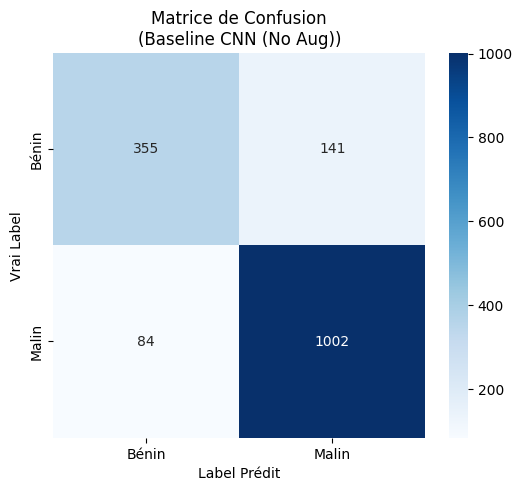


--- Évaluation Détaillée pour : Baseline CNN (With Aug) ---
Chargement du modèle depuis : baseline_cnn_augmented_model.keras
Calcul des prédictions sur le jeu de test...
Calcul des métriques...

Métriques pour Baseline CNN (With Aug):
  Accuracy (calculée): 0.9052
  Precision: 0.9341
  Recall (Sensitivity): 0.9273
  F1 Score: 0.9307
Génération de la matrice de confusion...


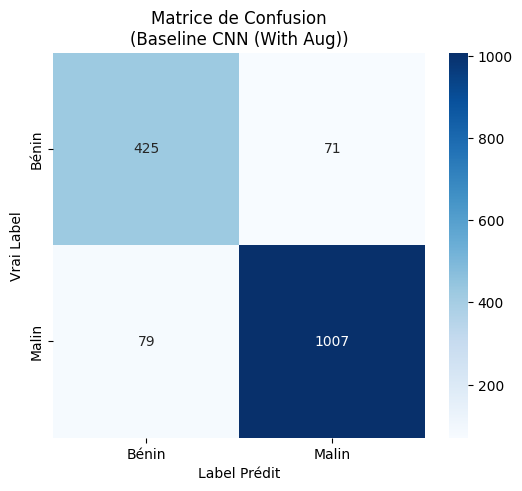


--- Évaluation Détaillée pour : Transfer Learning (DenseNet121) ---
Chargement du modèle depuis : transfer_learning_model.keras
Calcul des prédictions sur le jeu de test...
Calcul des métriques...

Métriques pour Transfer Learning (DenseNet121):
  Accuracy (calculée): 0.9570
  Precision: 0.9611
  Recall (Sensitivity): 0.9770
  F1 Score: 0.9689
Génération de la matrice de confusion...


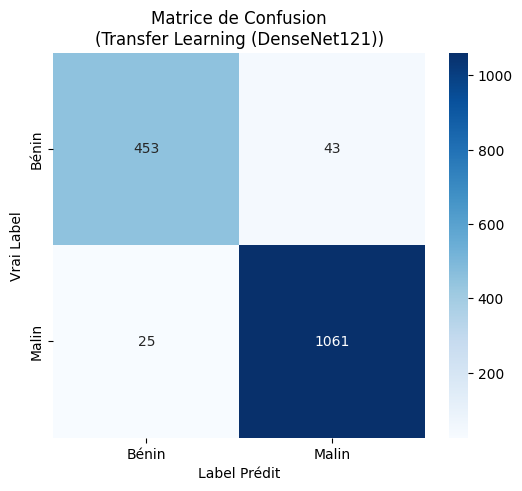


--- Fin de l'Évaluation Détaillée ---


In [ ]:
print("\n--- Évaluation Détaillée des Modèles ---")

# Préparer le dataset de test une seule fois (non augmenté, batch_size=1 pour évaluation individuelle)
print("Préparation du dataset de test pour l'évaluation détaillée...")
test_ds_eval = create_tf_dataset(
    X_test_paths,
    y_test,
    batch_size=1, 
    augment=False, # Pas d'augmentation sur le set de test
    num_classes=2
)
print("Dataset de test prêt.")

# Fonction pour évaluer un modèle et afficher les résultats
def evaluate_model_detailed(model_path, test_dataset, model_name):
    """Charge un modèle, l'évalue sur le dataset de test et affiche les métriques détaillées."""
    print(f"\n--- Évaluation Détaillée pour : {model_name} ---")
    print(f"Chargement du modèle depuis : {model_path}")

    try:
        # Charger le modèle
        model = tf.keras.models.load_model(model_path)

        y_true = []
        y_pred = []
        y_pred_proba = [] 

        print("Calcul des prédictions sur le jeu de test...")
        # Itérer sur le dataset de test pour obtenir prédictions et vraies étiquettes
        for images, labels in test_dataset: # batch_size est 1 ici
            true_label = np.argmax(labels.numpy(), axis=-1)[0] # Index de la classe réelle (0 ou 1)
            y_true.append(true_label)

            # Faire la prédiction
            predictions = model.predict(images, verbose=0) # verbose=0 pour éviter les barres de progression
            predicted_label = np.argmax(predictions, axis=-1)[0] # Index de la classe prédite
            y_pred.append(predicted_label)
            y_pred_proba.append(predictions[0]) # Garder les probas du premier (et seul) item du batch

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        print("Calcul des métriques...")
        # Calculer les métriques (pour binaire)
        accuracy = np.mean(y_true == y_pred) # Calcul manuel de l'accuracy pour vérifier
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

        print(f"\nMétriques pour {model_name}:")
        print(f"  Accuracy (calculée): {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall (Sensitivity): {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

        # Matrice de Confusion
        print("Génération de la matrice de confusion...")
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Bénin', 'Malin'], yticklabels=['Bénin', 'Malin'])
        plt.ylabel('Vrai Label')
        plt.xlabel('Label Prédit')
        plt.title(f'Matrice de Confusion\n({model_name})')
        plt.show()

    except FileNotFoundError:
        print(f"ERREUR: Fichier modèle non trouvé à l'emplacement {model_path}")
    except Exception as e:
        print(f"ERREUR: Une erreur est survenue lors de l'évaluation de {model_name}: {e}")

# --- Appeler la fonction d'évaluation pour chaque modèle sauvegardé ---

# 1. Modèle Baseline CNN (Sans Augmentation)
evaluate_model_detailed(
    model_path="baseline_cnn_model.keras", 
    test_dataset=test_ds_eval,
    model_name="Baseline CNN (No Aug)"
)

# 2. Modèle Baseline CNN (Avec Augmentation)
evaluate_model_detailed(
    model_path="baseline_cnn_augmented_model.keras", 
    test_dataset=test_ds_eval,
    model_name="Baseline CNN (With Aug)"
)

# 3. Modèle Transfer Learning (DenseNet121)
evaluate_model_detailed(
    model_path="transfer_learning_model.keras", 
    test_dataset=test_ds_eval,
    model_name="Transfer Learning (DenseNet121)"
)

print("\n--- Fin de l'Évaluation Détaillée ---")




--- Évaluation Détaillée du Meilleur Modèle ---

Métriques pour le modèle Transfer Learning:
  Precision: 0.9611
  Recall: 0.9770
  F1 Score: 0.9689


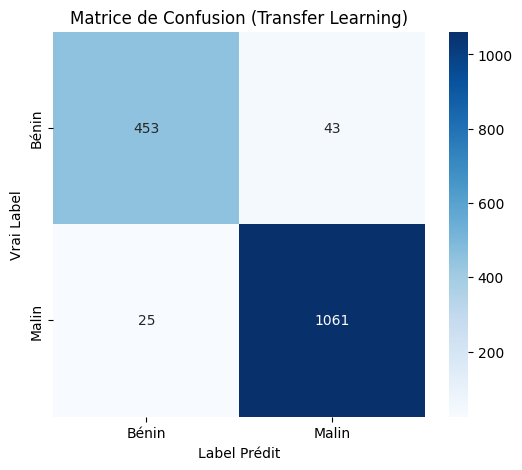

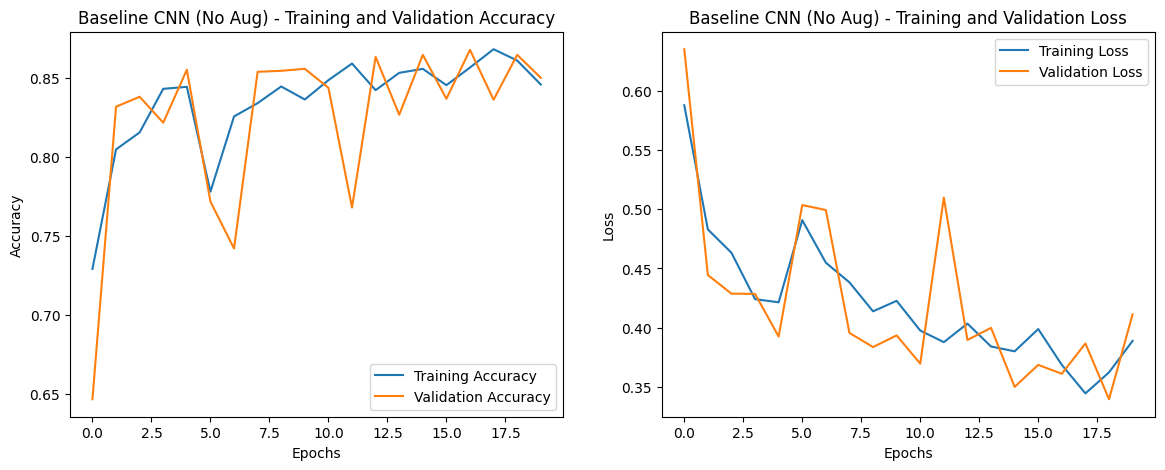

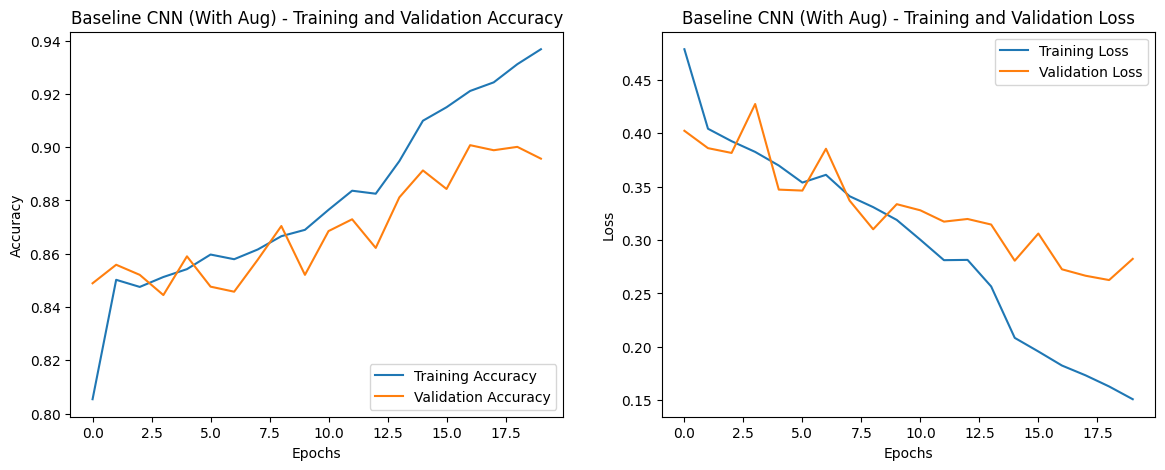

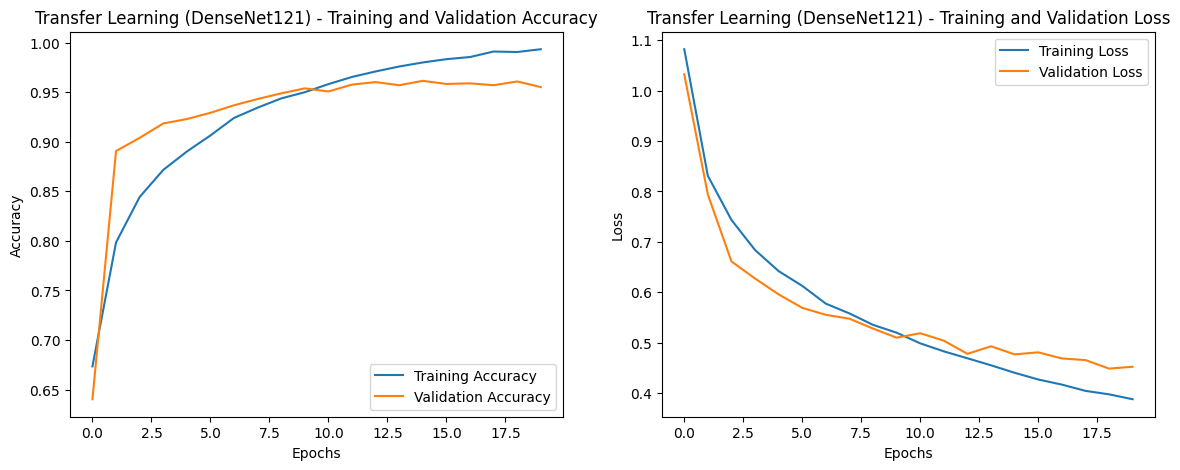

In [28]:
print("\n--- Évaluation Détaillée du Meilleur Modèle ---")

# Choisir le modèle à évaluer en détail 
best_model = transfer_model 
test_dataset_for_eval = test_ds_aug # Utiliser le dataset de test

y_true = []
y_pred_proba = []

# Obtenir les vraies étiquettes et les prédictions
# Assurer que le dataset de test n'est pas mélangé et batch_size=1 pour correspondance facile
test_ds_eval = create_tf_dataset(X_test_paths, y_test, batch_size=1, augment=False, num_classes=2) # batch_size=1, no shuffle implied

for images, labels in test_ds_eval: # Itérer sur le dataset de test (non augmenté, batch=1)
    preds = best_model.predict(images, verbose=0)
    y_true.append(np.argmax(labels.numpy(), axis=-1)[0]) # Index de la vraie classe
    y_pred_proba.append(preds[0]) # Garder les probabilités

y_true = np.array(y_true)
y_pred = np.argmax(np.array(y_pred_proba), axis=-1) # Index de la classe prédite

# Calculer les métriques
precision = precision_score(y_true, y_pred, average='binary') # 'binary' car 2 classes (0 ou 1)
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
print("\nMétriques pour le modèle Transfer Learning:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")

# Matrice de Confusion
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bénin', 'Malin'], yticklabels=['Bénin', 'Malin'])
plt.ylabel('Vrai Label')
plt.xlabel('Label Prédit')
plt.title('Matrice de Confusion (Transfer Learning)')
plt.show()

# Courbes d'entraînement 
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc)) # Utiliser la longueur réelle de l'historique

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()


plot_history(history_baseline, "Baseline CNN (No Aug)")
plot_history(history_baseline_aug, "Baseline CNN (With Aug)")
plot_history(history_transfer, "Transfer Learning (DenseNet121)")
